In [1]:
import os
import shutil
import random
import numpy as np
import cv2
import string
from tensorflow.keras import Model,Sequential,Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.measure import regionprops
from pytesseract import Output
import h5py
from sklearn.utils import shuffle
import pickle
import difflib
import nltk
nltk.download('abc')
nltk.download('brown')

[nltk_data] Downloading package abc to
[nltk_data]     C:\Users\Lucifer\AppData\Roaming\nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Lucifer\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
#total number of our output classes: len(char_list)
#char_list = string.ascii_letters+string.digits+string.punctuation
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [3]:
def preprocess(img, imgSize=(128,32), dataAugmentation=False):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"
    if img.ndim ==3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # increase dataset size by applying random stretches to the images
    if dataAugmentation:
        stretch = (random.random() - 0.5) # -0.5 .. +0.5
        wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
        img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5

    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    # scale according to f (result at least 1 and at most wt or ht)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) 
    img = cv2.resize(img, newSize)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img

    # transpose for TF
    #img = cv2.transpose(target)
    img = target

    # normalize
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    img = np.expand_dims(img , axis = 2)
    return img

In [4]:
def truncateLabel(text, maxTextLen):
    # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
    # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
    # If a too-long label is provided, ctc_loss returns an infinite gradient
    cost = 0
    for i in range(len(text)):
        if i != 0 and text[i] == text[i-1]:
            cost += 2
        else:
            cost += 1
        if cost > maxTextLen:
            return text[:i]
    return text

In [5]:
def load_data(maxTextLen = 20):
    chars = set()
    samples=[]
    bad_samples = []
    bad_samples_reference = ['a01-117-05-02.png', 'r06-022-03-05.png']
    lines =  open('data//words.txt')
    
    for i,line in enumerate(lines):
        if not line or line[0]=='#':
            continue
        lineSplit = line.strip().split(' ')
        # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
        fileNameSplit = lineSplit[0].split('-')
        fileName = 'data/words/' + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + lineSplit[0] + '.png'
            
        # check if image is not empty
        if not os.path.getsize(fileName) or lineSplit[1]=='err':
            bad_samples.append(lineSplit[0] + '.png')
            continue        
        
        # GT text are columns starting at 9
        gtText = truncateLabel(' '.join(lineSplit[8:]), maxTextLen)
        #encoded_txt=encode_to_labels(gtText)  
        chars = chars.union(set(list(gtText)))
        
        input_length = maxTextLen


        img = cv2.imread(fileName)
        img = preprocess(img)
        

        # put sample into list
        samples.append((gtText, img,input_length))
        
    charList = sorted(list(chars))

    return samples,charList

In [6]:
def load_data_digits(maxTextLen = 20):    
    samples_digit = []
    h5f = h5py.File('data/MNIST_synthetic.h5','r')
    X_train = h5f['train_dataset'][:,:,:,-1]
    y_train = h5f['train_labels'][:]

    input_length = maxTextLen


    for i,x in enumerate(X_train):
        image_digit = preprocess(X_train[i])
        image_label = y_train[i]


        # put sample into list
        samples_digit.append((image_label, image_digit,input_length))


    return samples_digit

In [68]:
maxTextLen = 32
samples,char_list = load_data(maxTextLen)
sample_digits = load_data_digits(maxTextLen)
sample = samples+sample_digits

In [ ]:
with open('data/IAM_MNIST_new', 'wb') as f:
    pickle.dump(sample, f)

# Start from here

In [7]:
with open('../HTRGC/IAM_MNIST_new', 'rb') as f:
    sample = pickle.load(f)
    
# Shuffle the dataset
sample = shuffle(sample)  


In [7]:
#Define char_list explicitly so that you do not need to call load_data multiple times
char_list = list(' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
maxTextLen = 32

In [9]:
maxTextLen = 32
# split into training and validation set: 95% - 5%
splitIdx = int(0.95 * len(sample))
trainSamples = sample[:splitIdx]
validationSamples = sample[splitIdx:]
# put words into lists
train_orig_txt = [x[0] for x in trainSamples]
training_txt = [encode_to_labels(str(x[0]))  for x in trainSamples]
training_img = [x[1] for x in trainSamples]
train_label_length = [len(x) for x in training_txt]
train_input_length = [x[2] for x in trainSamples]
train_padded_txt = pad_sequences(training_txt, maxlen=maxTextLen, padding='post', value = len(char_list))

valid_orig_txt = [x[0] for x in validationSamples]
valid_txt = [encode_to_labels(str(x[0])) for x in validationSamples]
valid_img = [x[1] for x in validationSamples]
valid_label_length = [len(x) for x in valid_txt]
valid_input_length = [x[2] for x in validationSamples]
valid_padded_txt = pad_sequences(valid_txt, maxlen=maxTextLen, padding='post', value = len(char_list))

In [10]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [153]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,3))
model = ResNet50(include_top=False,weights="imagenet",input_shape = (32,128,3))
# x=model.output
# x=Dense(80, activation = 'softmax')(x)
#model_final = Model(inputs,x)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 32, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 134, 3)   0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [8]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))

conv_1 = Conv2D(32,(5,5),activation = 'relu',padding = 'same')(inputs)
batch_norm_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(batch_norm_1)

conv_2 = Conv2D(64,(5,5),activation = 'relu',padding = 'same')(pool_1)
batch_norm_2 = BatchNormalization()(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(batch_norm_2)

conv_3 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(pool_2)
batch_norm_3 = BatchNormalization()(conv_3)
pool_3 = MaxPool2D(pool_size=(2,1), strides=(2,1))(batch_norm_3)

conv_4 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(pool_3)
batch_norm_4 = BatchNormalization()(conv_4)
pool_4 = MaxPool2D(pool_size=(2,1), strides=(2,1))(batch_norm_4)

conv_5 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
pool_5 = MaxPool2D(pool_size=(2,1), strides=(2,1))(batch_norm_5)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_5)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)
model_json = act_model.to_json()
with open('model/crnn_model', "w") as json_file:
    json_file.write(model_json)  
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 64)         0     

In [9]:
labels = Input(name='the_labels', shape=[maxTextLen], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [10]:
from tensorflow.keras.optimizers import Adam
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = Adam(learning_rate=0.0001))
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [14]:
model.load_weights('best_model.hdf5')

In [28]:
batch_size = 512
epochs = 5

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), 
          batch_size=batch_size, epochs = epochs, 
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
                             [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Train on 139131 samples, validate on 7323 samples
Epoch 1/5
138752/139131 [============================>.] - ETA: 14s - loss: 0.8122
Epoch 00001: val_loss improved from 0.89026 to 0.84530, saving model to best_model.hdf5
139131/139131 [==============================] - 5711s 41ms/sample - loss: 0.8120 - val_loss: 0.8453
Epoch 2/5
138752/139131 [============================>.] - ETA: 14s - loss: 0.7409
Epoch 00002: val_loss improved from 0.84530 to 0.80690, saving model to best_model.hdf5
139131/139131 [==============================] - 5772s 41ms/sample - loss: 0.7408 - val_loss: 0.8069
Epoch 3/5
138752/139131 [============================>.] - ETA: 15s - loss: 0.6829
Epoch 00003: val_loss improved from 0.80690 to 0.77817, saving model to best_model.hdf5
139131/139131 [==============================] - 6098s 44ms/sample - loss: 0.6835 - val_loss: 0.7782
Epoch 4/5
138752/139131 [============================>.] - ETA: 14s - loss: 0.6316
Epoch 00004: val_loss improved from 0.77817 to 0.75

In [16]:
# def load_model():
#     json_file = open('model/crnn_model', 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
#     model = model_from_json(loaded_model_json)
#     model.load_weights('"best_model.hdf5"')
#     print('[INFO] Model loaded')
#     return model

In [9]:
def get_pages(file=None, folder=None):
    page_names = []
    if file:
        directory = os.path.join('.', '')
        path = os.path.join('.', file)
        pages = convert_from_path(path)
        page_names = []
        for page in pages:
            imgfile = "{}-page_{}.jpg".format(''.join(file.split('.')[0:-1]), pages.index(page))
            page.save(os.path.join('.', imgfile), "JPEG")
            page_names.append(os.path.join('.', imgfile))
    if folder:
        directory = os.path.join(folder, '')
        for file in os.listdir(directory):
            if file.split('.')[-1] == 'pdf':
                path = os.path.join(directory, file)
                pages = convert_from_path(path)

                for page in pages:
                    imgfile = "{}-page_{}.jpg".format(file.split('.')[0], pages.index(page))
                    page.save(os.path.join(directory,'temp', imgfile), "JPEG")
                    page_names.append(os.path.join(directory,'temp', imgfile))
            if file.split('.')[-1] in ('jpg', 'png','PNG'):
                imgfile = file
                shutil.copy(os.path.join(directory, imgfile),os.path.join(directory,'temp', imgfile))
                page_names.append(os.path.join(directory,'temp', imgfile))
    return page_names
img_path = get_pages(folder = '../formfolder')
img_path

['../formfolder\\temp\\testDoc-page_0.jpg',
 '../formfolder\\temp\\testDoc-page_0.jpg']

In [10]:
def extract_connected_region(img):
    img_copy = img.copy()
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    img_copy = cv2.threshold(img_copy, 200, 255, cv2.THRESH_BINARY_INV)[1]
    rectKernel_out = cv2.getStructuringElement(cv2.MORPH_RECT, (5,2))
    img_copy_out = cv2.morphologyEx(img_copy, cv2.MORPH_CLOSE, rectKernel_out,iterations = 1)
    blobs = img_copy_out #> img_copy.mean()
    blobs_labels = measure.label(blobs, background=0, connectivity=2)

    conn_region = []
    for region in regionprops(blobs_labels):
        if region.bbox_area > 10:
            miny, minx, maxy, maxx = region.bbox
            text = [miny, minx, maxy, maxx]
            conn_region.append(text)

    # sorted(conn_region, key = lambda x: x[0])
    return conn_region

In [11]:
def extract_connected_region_outer(img):
    img_copy = img.copy()
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    img_copy = cv2.threshold(img_copy, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    rectKernel_out = cv2.getStructuringElement(cv2.MORPH_RECT, (4,2))
    img_copy_out = cv2.morphologyEx(img_copy, cv2.MORPH_CLOSE, rectKernel_out,iterations = 2)    
    blobs = img_copy_out #> img_copy.mean()
    blobs_labels = measure.label(blobs, background=0, connectivity=2)
    conn_region = []
    for region in regionprops(blobs_labels):
        if region.bbox_area > 100:   
            miny, minx, maxy, maxx = region.bbox
            text = [miny, minx, maxy, maxx]
            conn_region.append(text)
                
    #sorted(conn_region, key = lambda x: x[0])
    return conn_region

from WordSegmentation import wordSegmentation, prepareImg
act_model.load_weights('best_model.hdf5')
for i in img_path:
    image = cv2.imread(i)
    conn_region = extract_connected_region_outer(image)
    for j,region in enumerate(conn_region):
        if region[0]-3 > 0:
            miny = region[0]-3
        else:
            miny = region[0]
            
        if region[1]-3 > 0:
            minx = region[1]-3
        else:
            minx = region[1]


        orig_region = image[miny:region[2],minx:region[3]]
        imgs = prepareImg(orig_region, 50)
        res = wordSegmentation(imgs, kernelSize=15, sigma=11, theta=7, minArea=100)
        for (j, w) in enumerate(res):
            (wordBox, wordImg) = w
            (x, y, w, h) = wordBox
            orig_region = imgs[y:y+h,x:x+w]
            orig_region = preprocess(orig_region)
            orig_region = inc_contrast(orig_region)
            orig_region1=orig_region.copy()

    #         plt.imshow(orig_region1,cmap='gray')
    #         plt.show()        

            orig_region = np.expand_dims(orig_region , axis = [0,3])
            # predict outputs on validation images        
            prediction = act_model.predict(orig_region)
            #print(model.predict_proba)
#             import pytesseract
#             pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files (x86)\\Tesseract-OCR\\tesseract.exe'
#             config = ("-l eng --oem 4 --psm 7")
#             pytext = pytesseract.image_to_string(orig_region1)
#             print('pytext',pytext)

            # use CTC decoder
            out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                     greedy=True)[0][0])

            # see the results
            i = 0
            for x in out:
                print("predicted text = ", end = '')
                for p in x:  
                    if int(p) != -1:
                        print(char_list[int(p)], end = '')       
                print('\n')
                i+=1
            plt.imshow(orig_region1,cmap='gray')
            plt.show()

In [12]:
nltk.download('brown')
bow1=nltk.corpus.brown.words()
bow2=nltk.corpus.abc.words()
bow = list(set(bow1 + bow2))

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Lucifer\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [13]:
def inc_contrast(img):

    ekernel = np.ones((2,1), np.uint8)
    dkernel = np.ones((1,2), np.uint8)
    imgMorph = cv2.erode(img, ekernel, iterations = 1)
    imgMorph = cv2.dilate(imgMorph, dkernel, iterations = 1)
    #imgMorph = cv2.Canny(imgMorph,100,200)
    return imgMorph
#edges = cv.Canny(img,100,200)

act_model.load_weights('best_model.hdf5')
for i in img_path:
    image = cv2.imread(i)
    out_image = np.ones((image.shape[0],image.shape[1]))*255
    conn_region = extract_connected_region(image)

    for j,region in enumerate(conn_region):
        if region[0]-2 > 0:
            miny = region[0]-2
        else:
            miny = region[0]
            
        if region[1]-2 > 0:
            minx = region[1]-2
        else:
            minx = region[1]


        orig_region = image[miny:region[2],minx:region[3]]
        orig_region = preprocess(orig_region)
        orig_region = inc_contrast(orig_region)
        orig_region1=orig_region.copy()
             
       
        orig_region = np.expand_dims(orig_region , axis = [0,3])
        # predict outputs on validation images        
        prediction = act_model.predict(orig_region)
        #print(model.predict_proba)
#         import pytesseract
#         pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files (x86)\\Tesseract-OCR\\tesseract.exe'
#         config = ("-l eng --oem 4 --psm 12 -c preserve_interword_spaces=1")
#         pytext = pytesseract.image_to_string(image[region[0]-5:region[2],region[1]-5:region[3]], config=config)
#         print('pytext',pytext)

        # use CTC decoder
        out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                 greedy=True))
#         proba = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
#                                  greedy=True)[1][0]

        # see the results
        i = 0
        pred_text=''
        for x in out[0][0]:
            #print("predicted text = ", end = '')
            for p in x:  
                if int(p) != -1:
                    #print(char_list[int(p)], end = '')    
                    pred_text += char_list[int(p)]
            #print('\n')
            i+=1
        
        print("predicted text: ", pred_text)
        print('Confidence: ',out[1][0][0])
        closematch=difflib.get_close_matches(pred_text,bow,1,0.9)
        if closematch and out[1][0] >= 1:            
            print('Closest Match: ',closematch[0])
            pred_text = closematch[0]
        out_image= cv2.putText(out_image, pred_text, (region[1],region[2]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        plt.imshow(orig_region1,cmap='gray')
        plt.show()
    plt.imshow(out_image)
    plt.show()        
    cv2.imwrite('out_image.png',out_image)

In [25]:
def get_keys_values(img):
    img_copy = img.copy()
    h,w = img.shape[0], img.shape[1]
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35, 20))
    img_copy = cv2.morphologyEx(img_copy, cv2.MORPH_CLOSE, rectKernel,iterations = 1)
    blobs = img_copy > img_copy.mean()
    blobs_labels = measure.label(blobs, background=0, connectivity=1)
    keys = []
    values = []
    for i,region in enumerate(regionprops(blobs_labels)):
        miny, minx, maxy, maxx = region.bbox

        if minx < 0.3 * w and region.bbox_area > 1000:
            key = [miny, minx, maxy, maxx]
            keys.append(key)
        if minx > 0.5 * w:
            value = [miny, minx, maxy, maxx]
            values.append(value)

    return keys,values

In [26]:
def get_pairs(key,values):

    val_approx_miny = key[0] - 10
    val_approx_maxy = key[2] + 25
    found_value = 'N'
    for value in values:
        if value[0] >= val_approx_miny and value[2] <= val_approx_maxy:
            found_value = 'Y'
            return value
    if found_value == 'N':
        return ''

In [132]:
def extract_connected_region_inner(img,key_value_img,korv,visualize = False):
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 4))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, rectKernel,iterations = 1)
    blobs = img > img.mean()
    blobs_labels = measure.label(blobs, background=0, connectivity=1)
    conn_region = []
    for i,region in enumerate(regionprops(blobs_labels)):
        if region.bbox_area > 10:
            miny, minx, maxy, maxx = region.bbox
            text = [miny, minx, maxy, maxx]
            conn_region.append(text)

    conn_region.sort(key=lambda x:x[1])
    
    out_text = []
    for region in conn_region:
        miny, minx, maxy, maxx = region
        if miny-3 > 0:
            miny = miny-3
        else:
            miny = miny

        if minx-3 > 0:
            minx = minx-3
        else:
            minx = minx
            
        conn_region = key_value_img[miny:maxy,minx:maxx]
        conn_region = preprocess(conn_region)
        conn_region = inc_contrast(conn_region)
        conn_region1= conn_region.copy()
        conn_region = np.expand_dims(conn_region , axis = [0,3])
        # predict outputs on validation images        
        prediction = act_model.predict(conn_region)
        # use CTC decoder
        out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                 greedy=True))
        i = 0
        pred_text=''
        for x in out[0][0]:
            for p in x:  
                if int(p) != -1:
                    #print(char_list[int(p)], end = '')    
                    pred_text += char_list[int(p)]
            i+=1

        print("predicted text: ", pred_text)
        print('Confidence: ',out[1][0][0])
        
        if korv == 'key':
            #Less chance to see strange words in key, so get close match can be loose.
            closematch=difflib.get_close_matches(pred_text,bow,1,0.8)            
            if closematch and out[1][0] >= 0.5:            
                print('Closest Match: ',closematch[0])
                pred_text = closematch[0]
            out_text.append(pred_text)
            
        if korv == 'value':
            #High chance to see strange words in value, so get close match has to be be tight.
            closematch=difflib.get_close_matches(pred_text,bow,1,0.8)            
            if closematch and out[1][0] >= 1:            
                print('Closest Match: ',closematch[0])
                pred_text = closematch[0]
            out_text.append(pred_text)
            
        if visualize:
            plt.imshow(conn_region1,cmap='gray')
            plt.show()
    for i,text in enumerate(out_text):
        if len(text) == 1:
            out_text[i+1] = text+out_text[i+1]
            out_text.pop(i)
            
    final_text = ' '.join(out_text)

    return final_text

In [133]:
difflib.get_close_matches('hoad',bow,3,0.8) 

['hoard', 'had']

In [134]:
def search_string(fulldict,search_string):
    found = 'N'
    for key in fulldict:
        if search_string in key:
            print('Matching record found')
            print(fulldict[key])
            found = 'Y'
    if found == 'N':
        print('No matching record found')

predicted text:  Name
Confidence:  tf.Tensor(0.19109744, shape=(), dtype=float32)


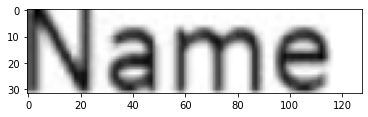

predicted text:  of
Confidence:  tf.Tensor(0.011199487, shape=(), dtype=float32)


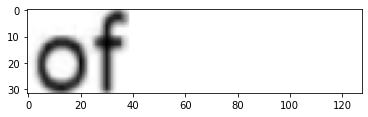

predicted text:  the
Confidence:  tf.Tensor(0.3450867, shape=(), dtype=float32)


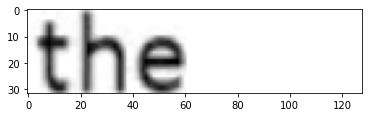

predicted text:  Enterprisel
Confidence:  tf.Tensor(0.23027892, shape=(), dtype=float32)


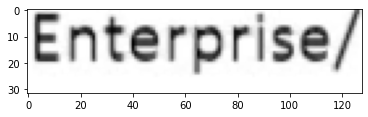

predicted text:  Individual
Confidence:  tf.Tensor(0.68021435, shape=(), dtype=float32)
Closest Match:  Individual


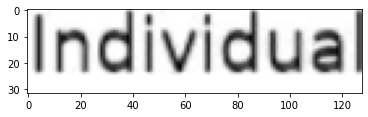

predicted text:  Abhash
Confidence:  tf.Tensor(0.07312065, shape=(), dtype=float32)


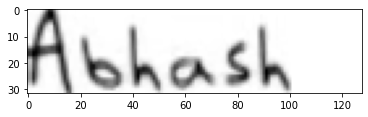

predicted text:  p
Confidence:  tf.Tensor(0.7273465, shape=(), dtype=float32)


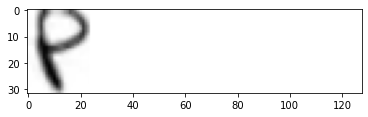

predicted text:  ryadarshi
Confidence:  tf.Tensor(2.4004965, shape=(), dtype=float32)
Closest Match:  radars


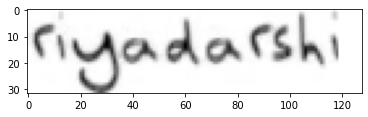

predicted text:  Resistered
Confidence:  tf.Tensor(0.11675817, shape=(), dtype=float32)


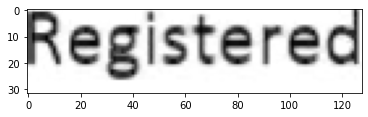

predicted text:  Office
Confidence:  tf.Tensor(0.69157916, shape=(), dtype=float32)
Closest Match:  Office


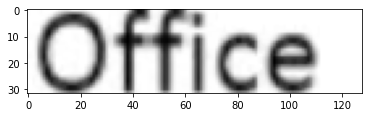

predicted text:  Address
Confidence:  tf.Tensor(0.024333484, shape=(), dtype=float32)


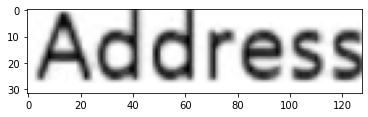

predicted text:  151
Confidence:  tf.Tensor(1.118137, shape=(), dtype=float32)
Closest Match:  151


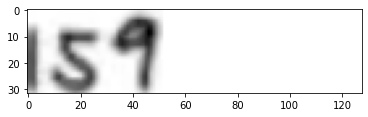

predicted text:  Deer
Confidence:  tf.Tensor(0.05025393, shape=(), dtype=float32)


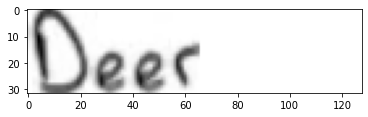

predicted text:  Valley
Confidence:  tf.Tensor(0.2436468, shape=(), dtype=float32)


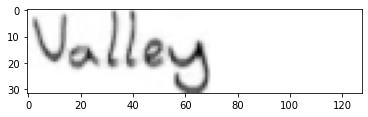

predicted text:  Road
Confidence:  tf.Tensor(0.63831747, shape=(), dtype=float32)


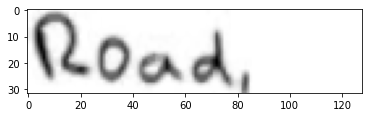

predicted text:  san
Confidence:  tf.Tensor(0.35854694, shape=(), dtype=float32)


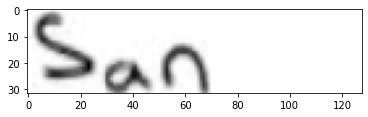

predicted text:  Ratacl
Confidence:  tf.Tensor(0.91433823, shape=(), dtype=float32)


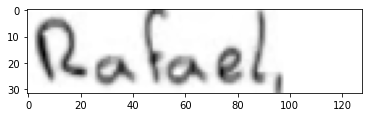

predicted text:  cA
Confidence:  tf.Tensor(0.5007583, shape=(), dtype=float32)


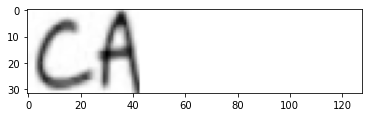

predicted text:  Address
Confidence:  tf.Tensor(0.04579345, shape=(), dtype=float32)


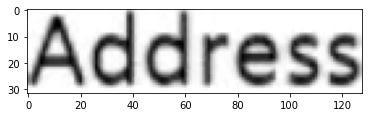

predicted text:  of
Confidence:  tf.Tensor(0.011554082, shape=(), dtype=float32)


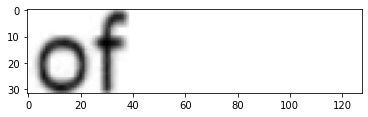

predicted text:  factory
Confidence:  tf.Tensor(0.028372627, shape=(), dtype=float32)


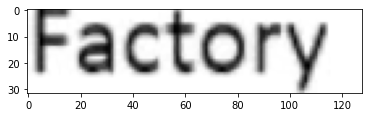

predicted text:  1shop
Confidence:  tf.Tensor(0.80006284, shape=(), dtype=float32)
Closest Match:  shop


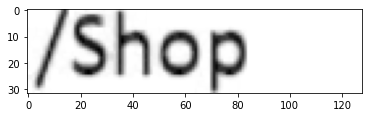

predicted text:  "
Confidence:  tf.Tensor(0.02505255, shape=(), dtype=float32)


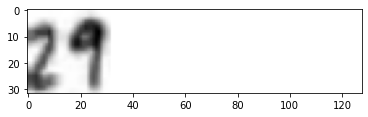

predicted text:  Marvel
Confidence:  tf.Tensor(0.57530695, shape=(), dtype=float32)


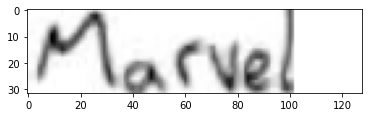

predicted text:  .
Confidence:  tf.Tensor(0.0910406, shape=(), dtype=float32)


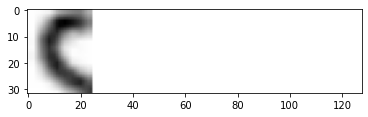

predicted text:  street
Confidence:  tf.Tensor(0.29388186, shape=(), dtype=float32)


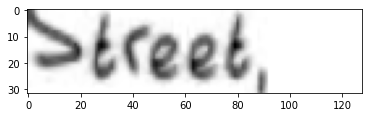

predicted text:  Los
Confidence:  tf.Tensor(0.44553685, shape=(), dtype=float32)


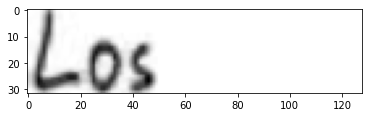

predicted text:  Angeles
Confidence:  tf.Tensor(1.1665995, shape=(), dtype=float32)
Closest Match:  Angeles


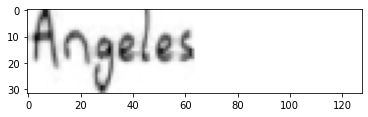

predicted text:  AA
Confidence:  tf.Tensor(2.28821, shape=(), dtype=float32)
Closest Match:  AA


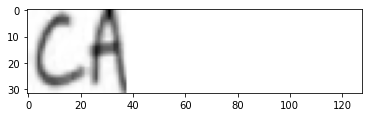

predicted text:  physically
Confidence:  tf.Tensor(0.7497866, shape=(), dtype=float32)
Closest Match:  physically


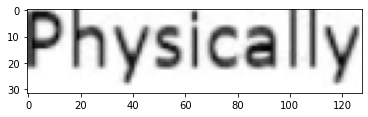

predicted text:  Handicapped
Confidence:  tf.Tensor(0.8358057, shape=(), dtype=float32)
Closest Match:  Handicapped


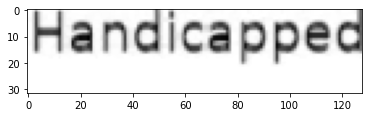

predicted text:  res
Confidence:  tf.Tensor(0.65361077, shape=(), dtype=float32)


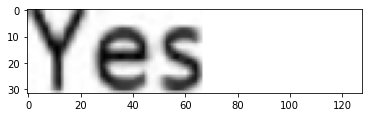

predicted text:  ,
Confidence:  tf.Tensor(0.9718137, shape=(), dtype=float32)
Closest Match:  ,


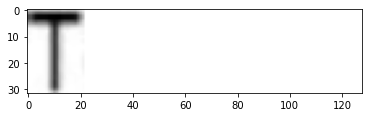

predicted text:  elephone
Confidence:  tf.Tensor(0.6630543, shape=(), dtype=float32)
Closest Match:  telephone


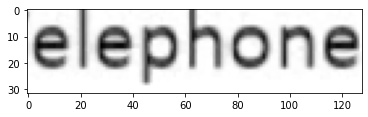

predicted text:  No.
Confidence:  tf.Tensor(0.9066614, shape=(), dtype=float32)
Closest Match:  No.


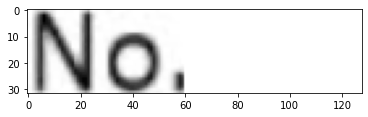

predicted text:  ono
Confidence:  tf.Tensor(1.1944625, shape=(), dtype=float32)
Closest Match:  onto


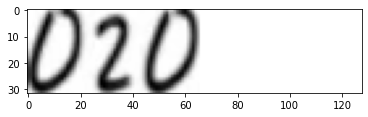

predicted text:  1344
Confidence:  tf.Tensor(1.0191113, shape=(), dtype=float32)
Closest Match:  144


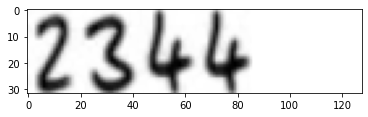

predicted text:  35121
Confidence:  tf.Tensor(0.87330824, shape=(), dtype=float32)


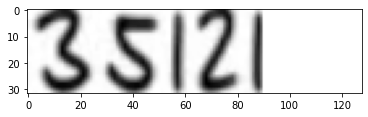

predicted text:  E
Confidence:  tf.Tensor(0.23449697, shape=(), dtype=float32)


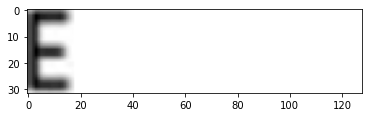

predicted text:  mail
Confidence:  tf.Tensor(0.65261453, shape=(), dtype=float32)
Closest Match:  mail


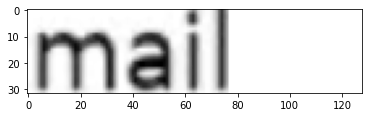

predicted text:  Address
Confidence:  tf.Tensor(0.09886782, shape=(), dtype=float32)


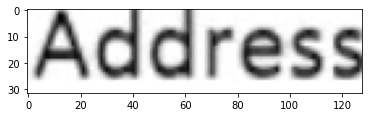

predicted text:  spark-
Confidence:  tf.Tensor(0.22290716, shape=(), dtype=float32)


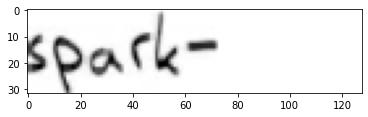

predicted text:  cunnelicovk
Confidence:  tf.Tensor(3.3682573, shape=(), dtype=float32)


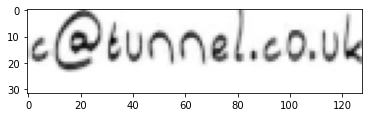

predicted text:  Mobile
Confidence:  tf.Tensor(0.84838974, shape=(), dtype=float32)
Closest Match:  Mobile


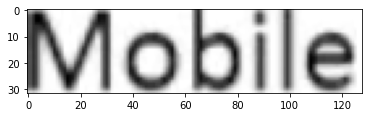

predicted text:  No.
Confidence:  tf.Tensor(0.46127698, shape=(), dtype=float32)


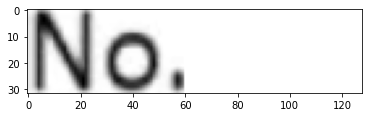

predicted text:  IkIs
Confidence:  tf.Tensor(2.0208585, shape=(), dtype=float32)


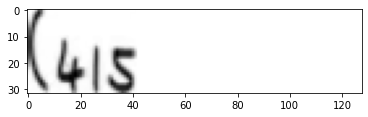

predicted text:  )
Confidence:  tf.Tensor(0.006954402, shape=(), dtype=float32)


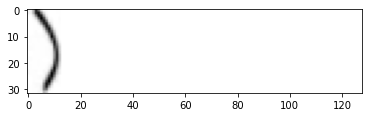

predicted text:  184
Confidence:  tf.Tensor(0.08723629, shape=(), dtype=float32)


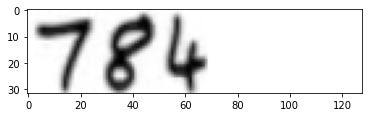

predicted text:  215
Confidence:  tf.Tensor(0.356909, shape=(), dtype=float32)


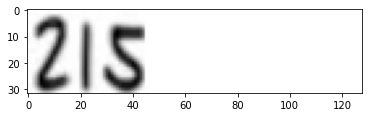

predicted text:  10
Confidence:  tf.Tensor(0.7731039, shape=(), dtype=float32)
Closest Match:  10


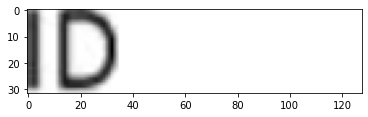

predicted text:  card
Confidence:  tf.Tensor(0.06784941, shape=(), dtype=float32)


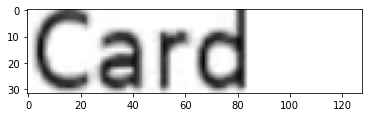

predicted text:  NO.
Confidence:  tf.Tensor(1.0504925, shape=(), dtype=float32)
Closest Match:  O.


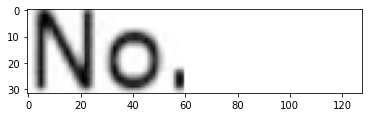

predicted text:  254501587235
Confidence:  tf.Tensor(3.5315888, shape=(), dtype=float32)


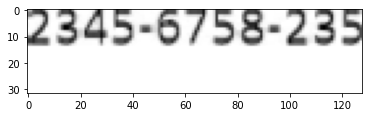

predicted text:  Constitution
Confidence:  tf.Tensor(0.5672593, shape=(), dtype=float32)
Closest Match:  Constitution


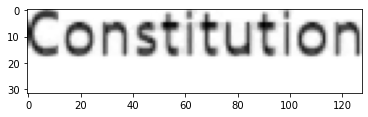

predicted text:  individuall
Confidence:  tf.Tensor(1.6506578, shape=(), dtype=float32)
Closest Match:  individually


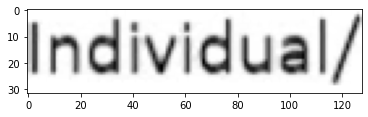

predicted text:  corserffernesrist
Confidence:  tf.Tensor(7.7359824, shape=(), dtype=float32)


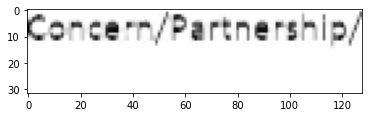

predicted text:  Limited
Confidence:  tf.Tensor(1.2367575, shape=(), dtype=float32)
Closest Match:  Limited


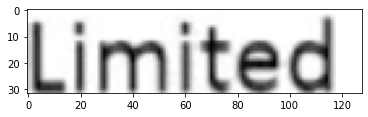

predicted text:  col
Confidence:  tf.Tensor(0.04715819, shape=(), dtype=float32)


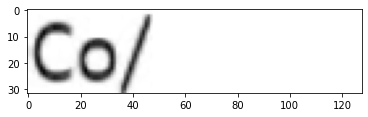

predicted text:  sointl
Confidence:  tf.Tensor(0.71970636, shape=(), dtype=float32)
Closest Match:  soil


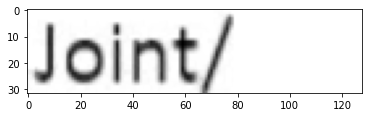

predicted text:  ,
Confidence:  tf.Tensor(0.49594945, shape=(), dtype=float32)


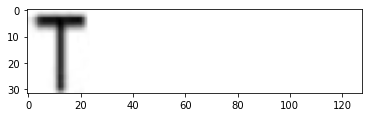

predicted text:  please
Confidence:  tf.Tensor(1.1521976, shape=(), dtype=float32)
Closest Match:  please


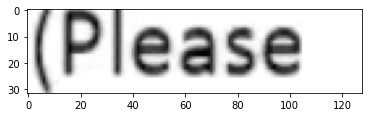

predicted text:  rustl
Confidence:  tf.Tensor(0.49668008, shape=(), dtype=float32)


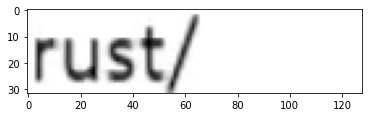

predicted text:  Prop.
Confidence:  tf.Tensor(1.1344974, shape=(), dtype=float32)
Closest Match:  Prop.


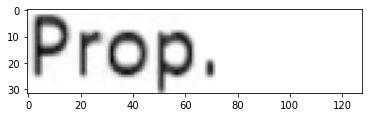

predicted text:  others
Confidence:  tf.Tensor(0.48371705, shape=(), dtype=float32)


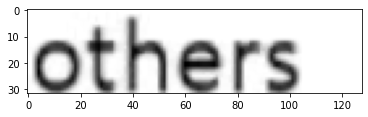

predicted text:  selectl
Confidence:  tf.Tensor(0.35202384, shape=(), dtype=float32)


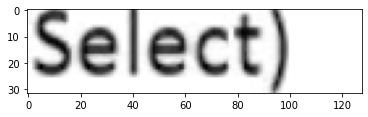

predicted text:  put
Confidence:  tf.Tensor(0.48142546, shape=(), dtype=float32)


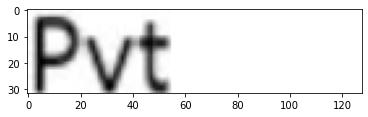

predicted text:  Ita
Confidence:  tf.Tensor(0.49347124, shape=(), dtype=float32)


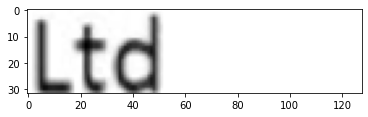

predicted text:  col
Confidence:  tf.Tensor(0.041074656, shape=(), dtype=float32)


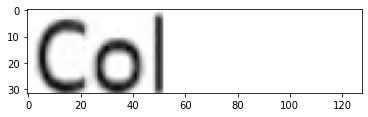

predicted text:  Corporation
Confidence:  tf.Tensor(0.759131, shape=(), dtype=float32)


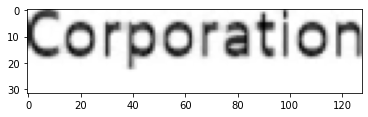

predicted text:  Private
Confidence:  tf.Tensor(0.9052414, shape=(), dtype=float32)


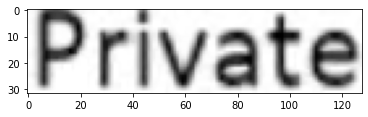

predicted text:  limited
Confidence:  tf.Tensor(1.3311825, shape=(), dtype=float32)
Closest Match:  limited


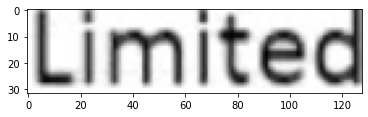

predicted text:  Date
Confidence:  tf.Tensor(0.10641579, shape=(), dtype=float32)


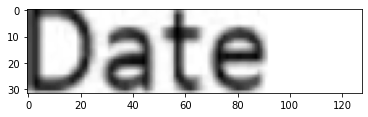

predicted text:  of
Confidence:  tf.Tensor(0.003906445, shape=(), dtype=float32)


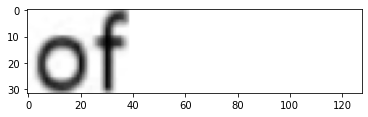

predicted text:  Establishmentl
Confidence:  tf.Tensor(1.9261457, shape=(), dtype=float32)
Closest Match:  establishment


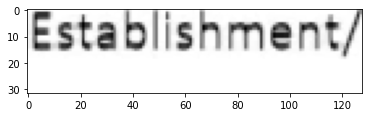

predicted text:  birth
Confidence:  tf.Tensor(0.7093466, shape=(), dtype=float32)
Closest Match:  birth


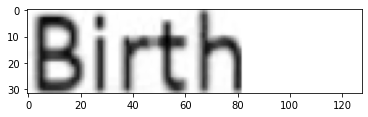

predicted text:  oal
Confidence:  tf.Tensor(0.44780937, shape=(), dtype=float32)


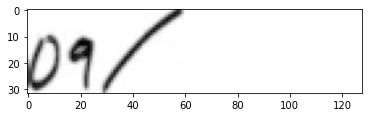

predicted text:  10
Confidence:  tf.Tensor(0.84331524, shape=(), dtype=float32)


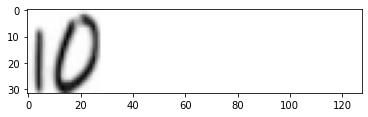

predicted text:  ,
Confidence:  tf.Tensor(0.48145556, shape=(), dtype=float32)


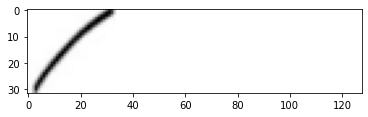

predicted text:  1965
Confidence:  tf.Tensor(0.2976998, shape=(), dtype=float32)


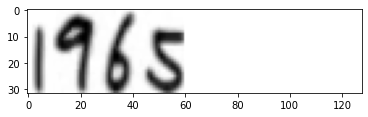

predicted text:  state
Confidence:  tf.Tensor(0.74755365, shape=(), dtype=float32)
Closest Match:  state


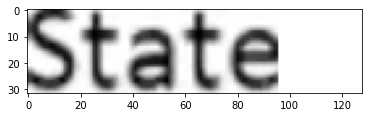

predicted text:  city
Confidence:  tf.Tensor(0.29189306, shape=(), dtype=float32)


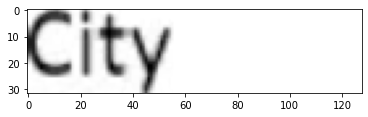

predicted text:  where
Confidence:  tf.Tensor(0.06802904, shape=(), dtype=float32)


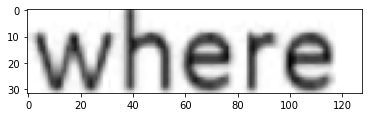

predicted text:  loan
Confidence:  tf.Tensor(0.08239, shape=(), dtype=float32)


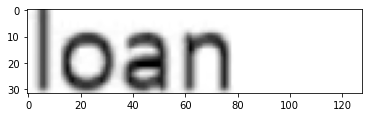

predicted text:  is
Confidence:  tf.Tensor(0.014772708, shape=(), dtype=float32)


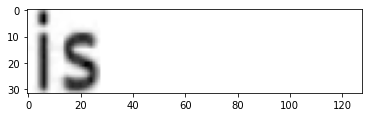

predicted text:  reauired
Confidence:  tf.Tensor(0.69083595, shape=(), dtype=float32)
Closest Match:  required


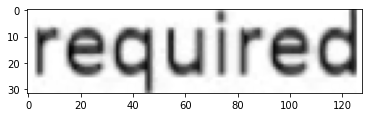

predicted text:  san
Confidence:  tf.Tensor(0.0063261148, shape=(), dtype=float32)


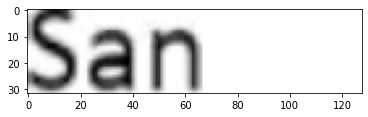

predicted text:  sose
Confidence:  tf.Tensor(0.6300239, shape=(), dtype=float32)


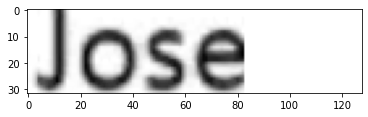

predicted text:  District
Confidence:  tf.Tensor(0.15585312, shape=(), dtype=float32)


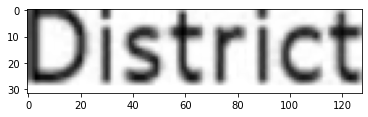

predicted text:  san
Confidence:  tf.Tensor(0.013396895, shape=(), dtype=float32)


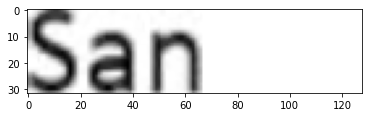

predicted text:  Ratael
Confidence:  tf.Tensor(1.4137048, shape=(), dtype=float32)
Closest Match:  Rafael


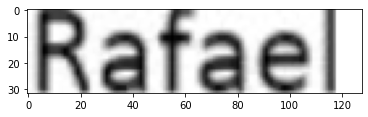

predicted text:  branch
Confidence:  tf.Tensor(0.12177056, shape=(), dtype=float32)


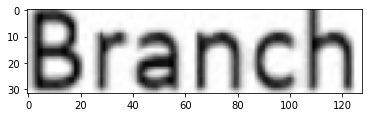

predicted text:  anyl
Confidence:  tf.Tensor(0.16796927, shape=(), dtype=float32)


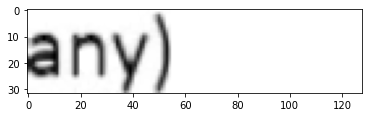

predicted text:  where
Confidence:  tf.Tensor(0.020890957, shape=(), dtype=float32)


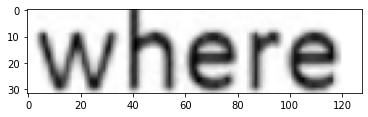

predicted text:  loan
Confidence:  tf.Tensor(0.017203657, shape=(), dtype=float32)


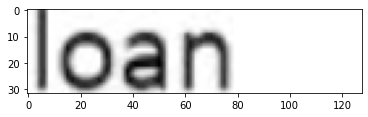

predicted text:  is
Confidence:  tf.Tensor(0.0041206935, shape=(), dtype=float32)


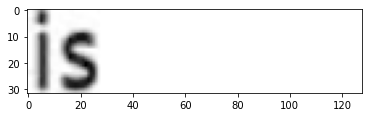

predicted text:  required
Confidence:  tf.Tensor(1.0590749, shape=(), dtype=float32)
Closest Match:  required


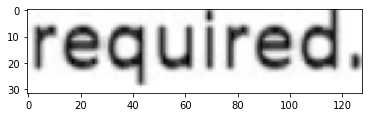

predicted text:  It
Confidence:  tf.Tensor(0.3539733, shape=(), dtype=float32)


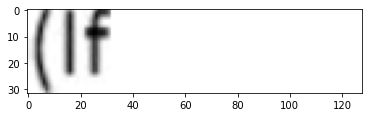

predicted text:  Ciby
Confidence:  tf.Tensor(0.58981895, shape=(), dtype=float32)


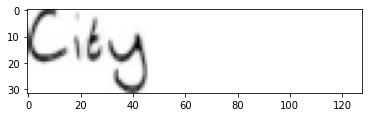

predicted text:  Center
Confidence:  tf.Tensor(0.115971714, shape=(), dtype=float32)


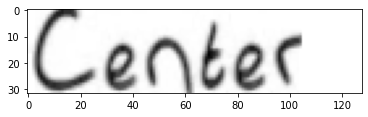

predicted text:  Name
Confidence:  tf.Tensor(0.19109744, shape=(), dtype=float32)


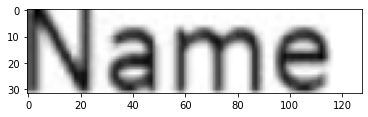

predicted text:  of
Confidence:  tf.Tensor(0.011199487, shape=(), dtype=float32)


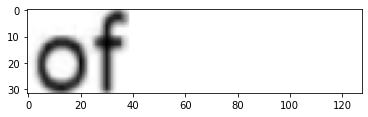

predicted text:  the
Confidence:  tf.Tensor(0.3450867, shape=(), dtype=float32)


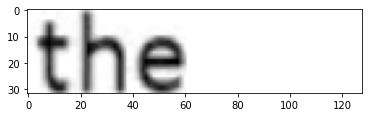

predicted text:  Enterprisel
Confidence:  tf.Tensor(0.23027892, shape=(), dtype=float32)


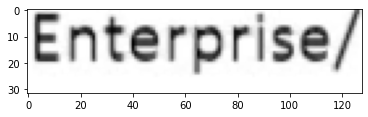

predicted text:  Individual
Confidence:  tf.Tensor(0.68021435, shape=(), dtype=float32)
Closest Match:  Individual


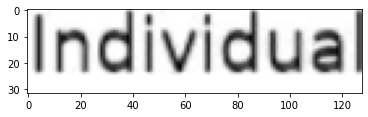

predicted text:  Abhash
Confidence:  tf.Tensor(0.07312065, shape=(), dtype=float32)


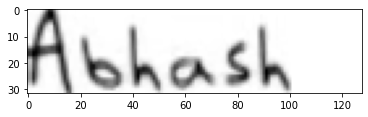

predicted text:  p
Confidence:  tf.Tensor(0.7273465, shape=(), dtype=float32)


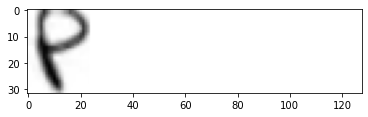

predicted text:  ryadarshi
Confidence:  tf.Tensor(2.4004965, shape=(), dtype=float32)
Closest Match:  radars


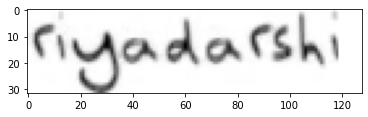

predicted text:  Resistered
Confidence:  tf.Tensor(0.11675817, shape=(), dtype=float32)


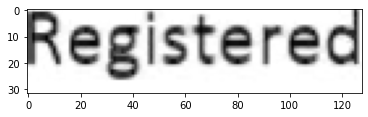

predicted text:  Office
Confidence:  tf.Tensor(0.69157916, shape=(), dtype=float32)
Closest Match:  Office


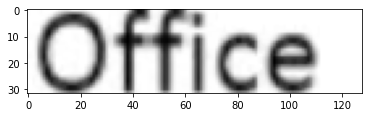

predicted text:  Address
Confidence:  tf.Tensor(0.024333484, shape=(), dtype=float32)


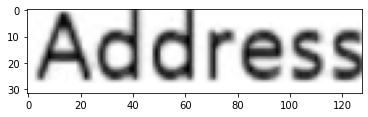

predicted text:  151
Confidence:  tf.Tensor(1.118137, shape=(), dtype=float32)
Closest Match:  151


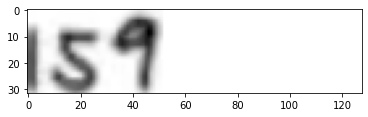

predicted text:  Deer
Confidence:  tf.Tensor(0.05025393, shape=(), dtype=float32)


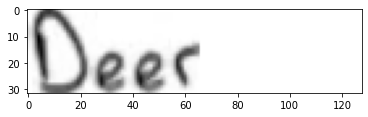

predicted text:  Valley
Confidence:  tf.Tensor(0.2436468, shape=(), dtype=float32)


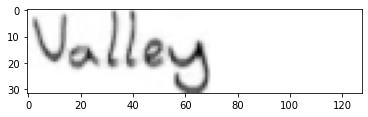

predicted text:  Road
Confidence:  tf.Tensor(0.63831747, shape=(), dtype=float32)


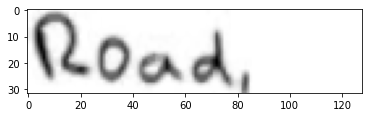

predicted text:  san
Confidence:  tf.Tensor(0.35854694, shape=(), dtype=float32)


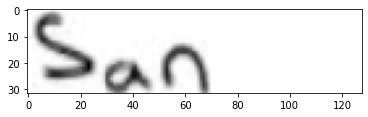

predicted text:  Ratacl
Confidence:  tf.Tensor(0.91433823, shape=(), dtype=float32)


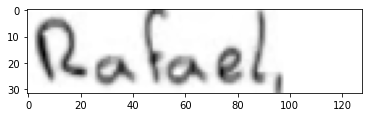

predicted text:  cA
Confidence:  tf.Tensor(0.5007583, shape=(), dtype=float32)


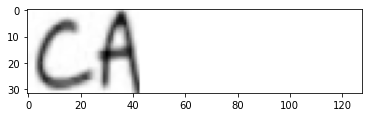

predicted text:  Address
Confidence:  tf.Tensor(0.04579345, shape=(), dtype=float32)


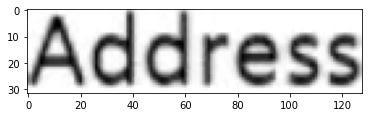

predicted text:  of
Confidence:  tf.Tensor(0.011554082, shape=(), dtype=float32)


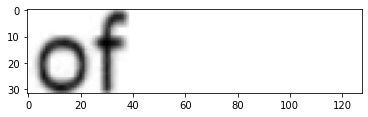

predicted text:  factory
Confidence:  tf.Tensor(0.028372627, shape=(), dtype=float32)


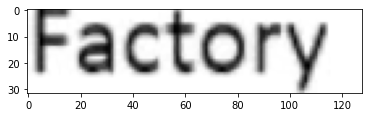

predicted text:  1shop
Confidence:  tf.Tensor(0.80006284, shape=(), dtype=float32)
Closest Match:  shop


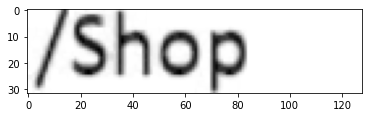

predicted text:  "
Confidence:  tf.Tensor(0.02505255, shape=(), dtype=float32)


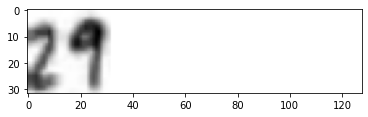

predicted text:  Marvel
Confidence:  tf.Tensor(0.57530695, shape=(), dtype=float32)


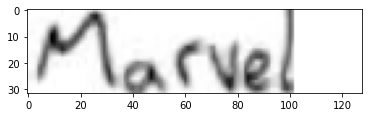

predicted text:  .
Confidence:  tf.Tensor(0.0910406, shape=(), dtype=float32)


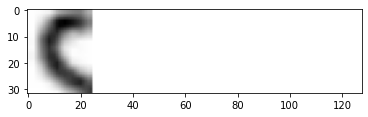

predicted text:  street
Confidence:  tf.Tensor(0.29388186, shape=(), dtype=float32)


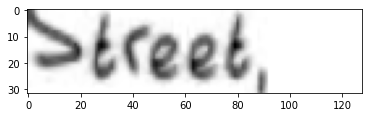

predicted text:  Los
Confidence:  tf.Tensor(0.44553685, shape=(), dtype=float32)


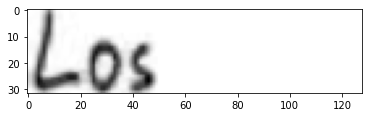

predicted text:  Angeles
Confidence:  tf.Tensor(1.1665995, shape=(), dtype=float32)
Closest Match:  Angeles


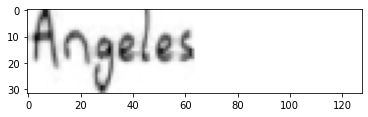

predicted text:  AA
Confidence:  tf.Tensor(2.28821, shape=(), dtype=float32)
Closest Match:  AA


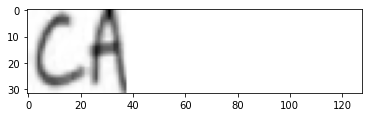

predicted text:  physically
Confidence:  tf.Tensor(0.7497866, shape=(), dtype=float32)
Closest Match:  physically


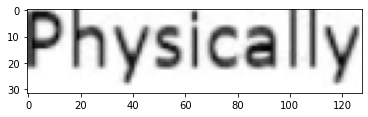

predicted text:  Handicapped
Confidence:  tf.Tensor(0.8358057, shape=(), dtype=float32)
Closest Match:  Handicapped


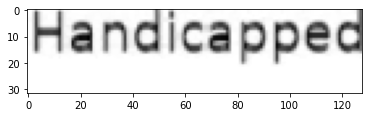

predicted text:  res
Confidence:  tf.Tensor(0.65361077, shape=(), dtype=float32)


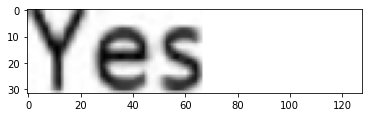

predicted text:  ,
Confidence:  tf.Tensor(0.9718137, shape=(), dtype=float32)
Closest Match:  ,


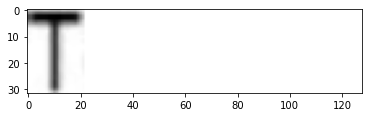

predicted text:  elephone
Confidence:  tf.Tensor(0.6630543, shape=(), dtype=float32)
Closest Match:  telephone


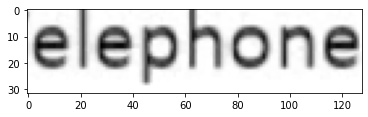

predicted text:  No.
Confidence:  tf.Tensor(0.9066614, shape=(), dtype=float32)
Closest Match:  No.


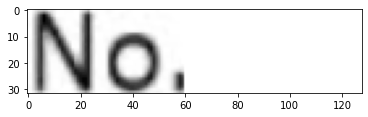

predicted text:  ono
Confidence:  tf.Tensor(1.1944625, shape=(), dtype=float32)
Closest Match:  onto


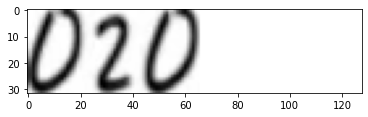

predicted text:  1344
Confidence:  tf.Tensor(1.0191113, shape=(), dtype=float32)
Closest Match:  144


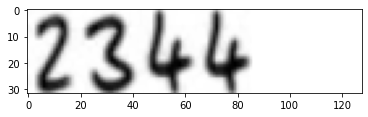

predicted text:  35121
Confidence:  tf.Tensor(0.87330824, shape=(), dtype=float32)


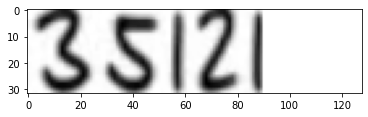

predicted text:  E
Confidence:  tf.Tensor(0.23449697, shape=(), dtype=float32)


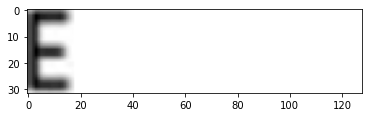

predicted text:  mail
Confidence:  tf.Tensor(0.65261453, shape=(), dtype=float32)
Closest Match:  mail


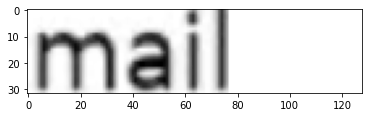

predicted text:  Address
Confidence:  tf.Tensor(0.09886782, shape=(), dtype=float32)


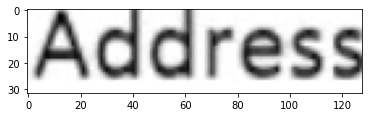

predicted text:  spark-
Confidence:  tf.Tensor(0.22290716, shape=(), dtype=float32)


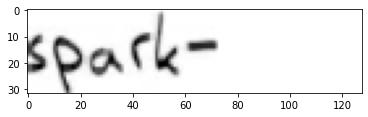

predicted text:  cunnelicovk
Confidence:  tf.Tensor(3.3682573, shape=(), dtype=float32)


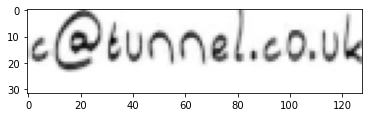

predicted text:  Mobile
Confidence:  tf.Tensor(0.84838974, shape=(), dtype=float32)
Closest Match:  Mobile


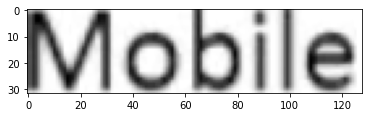

predicted text:  No.
Confidence:  tf.Tensor(0.46127698, shape=(), dtype=float32)


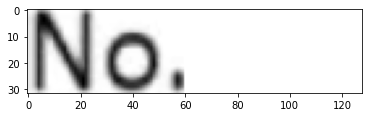

predicted text:  IkIs
Confidence:  tf.Tensor(2.0208585, shape=(), dtype=float32)


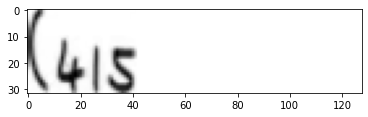

predicted text:  )
Confidence:  tf.Tensor(0.006954402, shape=(), dtype=float32)


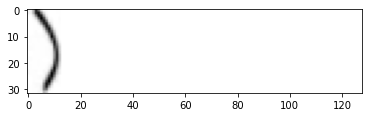

predicted text:  184
Confidence:  tf.Tensor(0.08723629, shape=(), dtype=float32)


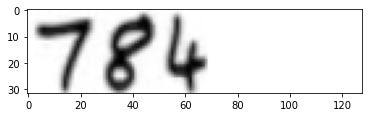

predicted text:  215
Confidence:  tf.Tensor(0.356909, shape=(), dtype=float32)


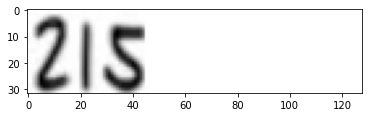

predicted text:  10
Confidence:  tf.Tensor(0.7731039, shape=(), dtype=float32)
Closest Match:  10


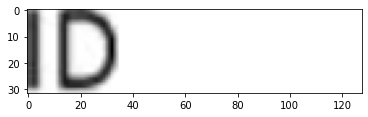

predicted text:  card
Confidence:  tf.Tensor(0.06784941, shape=(), dtype=float32)


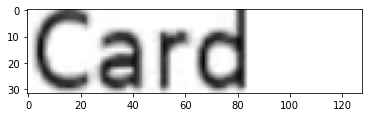

predicted text:  NO.
Confidence:  tf.Tensor(1.0504925, shape=(), dtype=float32)
Closest Match:  O.


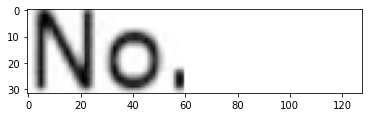

predicted text:  254501587235
Confidence:  tf.Tensor(3.5315888, shape=(), dtype=float32)


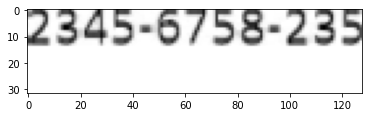

predicted text:  Constitution
Confidence:  tf.Tensor(0.5672593, shape=(), dtype=float32)
Closest Match:  Constitution


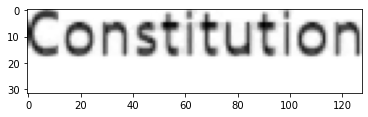

predicted text:  individuall
Confidence:  tf.Tensor(1.6506578, shape=(), dtype=float32)
Closest Match:  individually


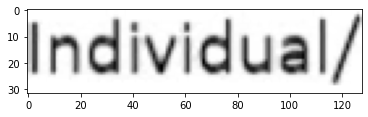

predicted text:  corserffernesrist
Confidence:  tf.Tensor(7.7359824, shape=(), dtype=float32)


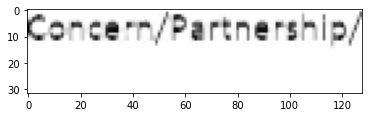

predicted text:  Limited
Confidence:  tf.Tensor(1.2367575, shape=(), dtype=float32)
Closest Match:  Limited


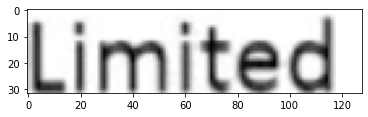

predicted text:  col
Confidence:  tf.Tensor(0.04715819, shape=(), dtype=float32)


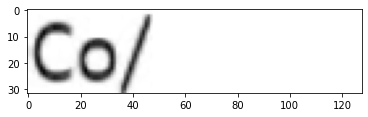

predicted text:  sointl
Confidence:  tf.Tensor(0.71970636, shape=(), dtype=float32)
Closest Match:  soil


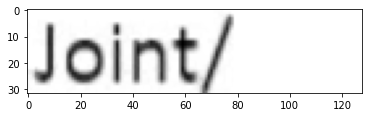

predicted text:  ,
Confidence:  tf.Tensor(0.49594945, shape=(), dtype=float32)


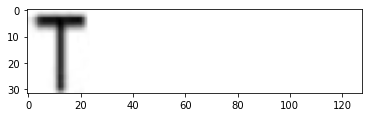

predicted text:  please
Confidence:  tf.Tensor(1.1521976, shape=(), dtype=float32)
Closest Match:  please


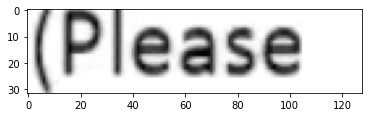

predicted text:  rustl
Confidence:  tf.Tensor(0.49668008, shape=(), dtype=float32)


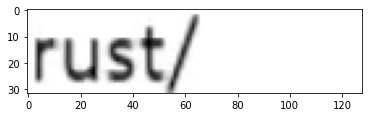

predicted text:  Prop.
Confidence:  tf.Tensor(1.1344974, shape=(), dtype=float32)
Closest Match:  Prop.


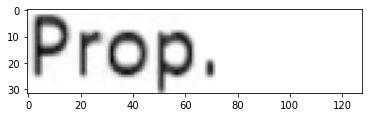

predicted text:  others
Confidence:  tf.Tensor(0.48371705, shape=(), dtype=float32)


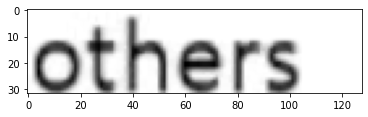

predicted text:  selectl
Confidence:  tf.Tensor(0.35202384, shape=(), dtype=float32)


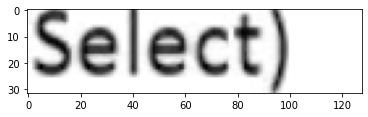

predicted text:  put
Confidence:  tf.Tensor(0.48142546, shape=(), dtype=float32)


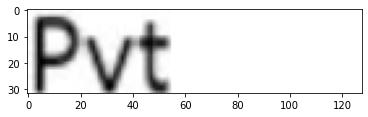

predicted text:  Ita
Confidence:  tf.Tensor(0.49347124, shape=(), dtype=float32)


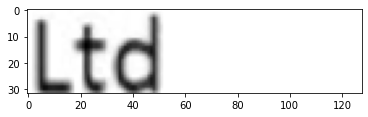

predicted text:  col
Confidence:  tf.Tensor(0.041074656, shape=(), dtype=float32)


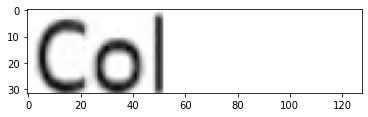

predicted text:  Corporation
Confidence:  tf.Tensor(0.759131, shape=(), dtype=float32)


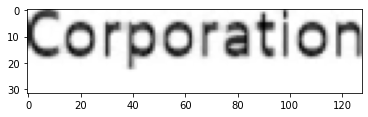

predicted text:  Private
Confidence:  tf.Tensor(0.9052414, shape=(), dtype=float32)


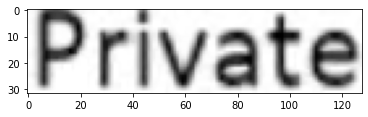

predicted text:  limited
Confidence:  tf.Tensor(1.3311825, shape=(), dtype=float32)
Closest Match:  limited


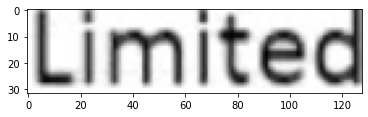

predicted text:  Date
Confidence:  tf.Tensor(0.10641579, shape=(), dtype=float32)


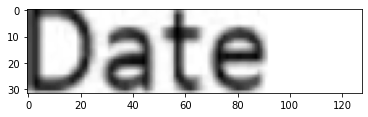

predicted text:  of
Confidence:  tf.Tensor(0.003906445, shape=(), dtype=float32)


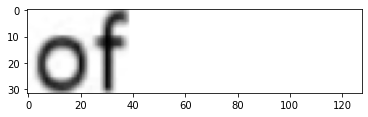

predicted text:  Establishmentl
Confidence:  tf.Tensor(1.9261457, shape=(), dtype=float32)
Closest Match:  establishment


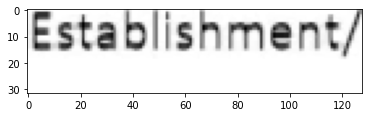

predicted text:  birth
Confidence:  tf.Tensor(0.7093466, shape=(), dtype=float32)
Closest Match:  birth


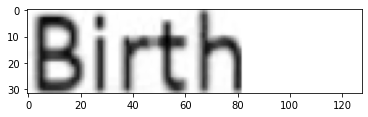

predicted text:  oal
Confidence:  tf.Tensor(0.44780937, shape=(), dtype=float32)


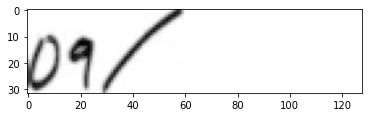

predicted text:  10
Confidence:  tf.Tensor(0.84331524, shape=(), dtype=float32)


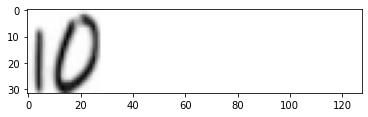

predicted text:  ,
Confidence:  tf.Tensor(0.48145556, shape=(), dtype=float32)


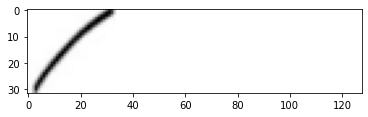

predicted text:  1965
Confidence:  tf.Tensor(0.2976998, shape=(), dtype=float32)


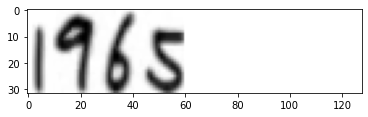

predicted text:  state
Confidence:  tf.Tensor(0.74755365, shape=(), dtype=float32)
Closest Match:  state


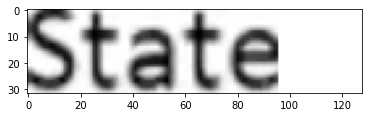

predicted text:  city
Confidence:  tf.Tensor(0.29189306, shape=(), dtype=float32)


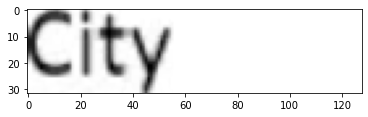

predicted text:  where
Confidence:  tf.Tensor(0.06802904, shape=(), dtype=float32)


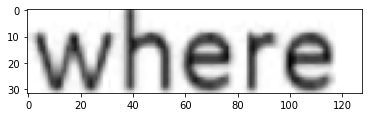

predicted text:  loan
Confidence:  tf.Tensor(0.08239, shape=(), dtype=float32)


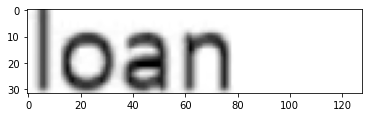

predicted text:  is
Confidence:  tf.Tensor(0.014772708, shape=(), dtype=float32)


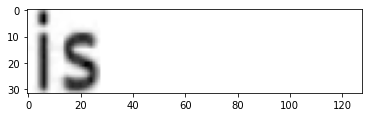

predicted text:  reauired
Confidence:  tf.Tensor(0.69083595, shape=(), dtype=float32)
Closest Match:  required


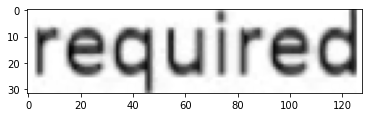

predicted text:  san
Confidence:  tf.Tensor(0.0063261148, shape=(), dtype=float32)


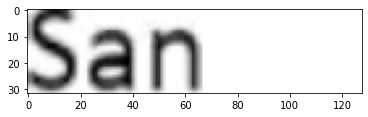

predicted text:  sose
Confidence:  tf.Tensor(0.6300239, shape=(), dtype=float32)


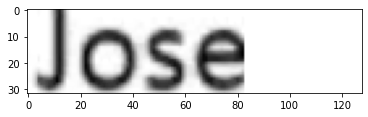

predicted text:  District
Confidence:  tf.Tensor(0.15585312, shape=(), dtype=float32)


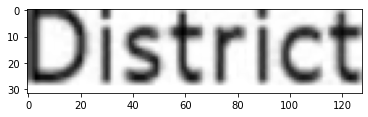

predicted text:  san
Confidence:  tf.Tensor(0.013396895, shape=(), dtype=float32)


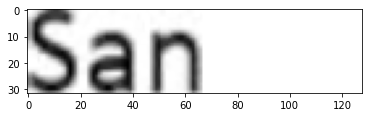

predicted text:  Ratael
Confidence:  tf.Tensor(1.4137048, shape=(), dtype=float32)
Closest Match:  Rafael


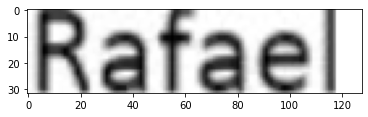

predicted text:  branch
Confidence:  tf.Tensor(0.12177056, shape=(), dtype=float32)


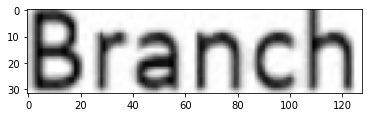

predicted text:  anyl
Confidence:  tf.Tensor(0.16796927, shape=(), dtype=float32)


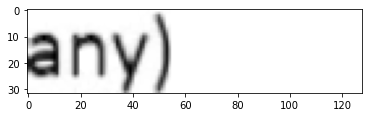

predicted text:  where
Confidence:  tf.Tensor(0.020890957, shape=(), dtype=float32)


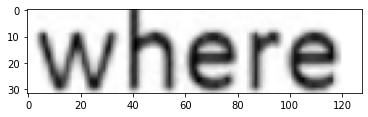

predicted text:  loan
Confidence:  tf.Tensor(0.017203657, shape=(), dtype=float32)


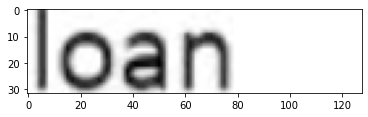

predicted text:  is
Confidence:  tf.Tensor(0.0041206935, shape=(), dtype=float32)


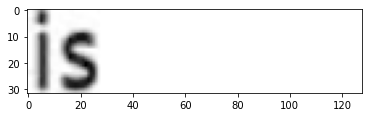

predicted text:  required
Confidence:  tf.Tensor(1.0590749, shape=(), dtype=float32)
Closest Match:  required


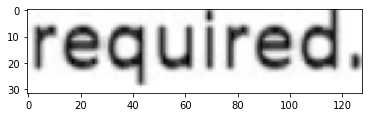

predicted text:  It
Confidence:  tf.Tensor(0.3539733, shape=(), dtype=float32)


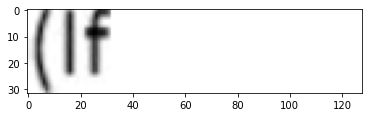

predicted text:  Ciby
Confidence:  tf.Tensor(0.58981895, shape=(), dtype=float32)


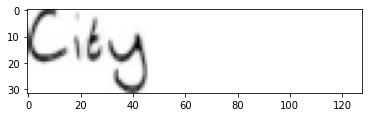

predicted text:  Center
Confidence:  tf.Tensor(0.115971714, shape=(), dtype=float32)


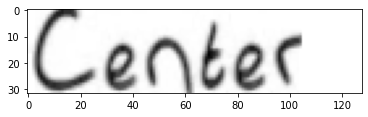

In [135]:
act_model.load_weights('best_model.hdf5')
for i in img_path:
    img = cv2.imread(i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)[1]
    pairs={}
    keys,values = get_keys_values(gray)
    for key in keys:
        key_image = img[key[0]:key[2],key[1]:key[3]]
        gray_key = cv2.cvtColor(key_image, cv2.COLOR_BGR2GRAY)
        gray_key = cv2.threshold(gray_key, 150, 255, cv2.THRESH_BINARY_INV)[1]   
        
        key_text = extract_connected_region_inner(gray_key,key_image,'key',visualize = True)
        
        value = get_pairs(key,values)
        if value:
            value_image = img[value[0]:value[2], value[1]:value[3]]
            gray_value = cv2.cvtColor(value_image, cv2.COLOR_BGR2GRAY)
            gray_value = cv2.threshold(gray_value, 150, 255, cv2.THRESH_BINARY_INV)[1]
            
            value_text = extract_connected_region_inner(gray_value,value_image,'value',visualize = True)
            
            pairs.update({key_text:value_text})
        else:
            value_text = 'Blank'
            pairs.update({key_text:value_text})
            


In [142]:
search_string(pairs,'Address')

Matching record found
151 Deer Valley Road san Ratacl cA
Matching record found
"Marvel .street Los Angeles AA
Matching record found
spark- cunnelicovk


In [80]:
1*np.exp(0.5)

1.6487212707001282